Dieses Skript führt einen Häufigkeitsangriff auf einen verschlüsselten Text durch.

GRUNDIDEE:
- In jeder Sprache kommen bestimmte Buchstaben häufiger vor als andere
- Im Deutschen ist z.B. 'E' der häufigste Buchstabe (16%)
- Bei einer Substitutionschiffre werden Buchstaben 1:1 ersetzt (A->X, B->Y, etc.)
- Wenn wir die häufigsten Buchstaben im Geheimtext mit den häufigsten
  deutschen Buchstaben vergleichen, können wir Vermutungen anstellen

ABLAUF:
1. Lade deutsche Häufigkeitstabellen (Monogramme, Bigramme, Trigramme)
2. Analysiere den Geheimtext und zähle dessen Häufigkeiten
3. Ordne die häufigsten Geheimtext-Buchstaben den häufigsten deutschen zu
4. Wende diese Zuordnung an und erhalte einen ersten Entschlüsselungsversuch

In [ ]:
import pandas as pd  # Für datenmanipulation
from pathlib import Path # Für Dateipfade
import matplotlib.pyplot as plt # Für Visualisierungen

def safe_read_freq_csv(path, index_col_name):
    """
    Liest eine CSV-Datei mit Häufigkeiten sicher ein.
    
    PARAMETER:
    - path: Pfad zur CSV-Datei (z.B. 'de_mono.csv')
    - index_col_name: Name der Spalte, die als Index verwendet werden soll
    
    RÜCKGABE:
    - Pandas Series mit Häufigkeiten, sortiert absteigend
    - Falls Datei nicht existiert: leere Series
    
    BEISPIEL CSV-FORMAT (de_mono.csv):
    Buchstabe,Häufigkeit
    E,0.1609
    N,0.0886
    I,0.0774
    ...
    """
    p = Path(path)
    if not p.exists():
        print(f"Warning: '{path}' not found. Creating empty frequency Series for '{index_col_name}'.")
        df = pd.DataFrame(columns=[index_col_name, 'Häufigkeit'])
    else:
        df = pd.read_csv(p)
    if index_col_name in df.columns and 'Häufigkeit' in df.columns:
        return df.set_index(index_col_name)['Häufigkeit'].sort_values(ascending=False)
    else:
        return pd.Series(dtype=float, name='Häufigkeit')

# Lade die Häufigkeitsdaten
DE_MONO_FREQ = safe_read_freq_csv('de_mono.csv', 'Buchstabe')
DE_BI_FREQ = safe_read_freq_csv('de_bi.csv', 'Biagramm')
DE_TRI_FREQ = safe_read_freq_csv('de_tri.csv', 'Triagramm')

# Konvertiere zu Dictionaries
DE_MONO_FREQ_DICT = DE_MONO_FREQ.to_dict()
DE_MONO_CHARS = list(DE_MONO_FREQ_DICT.keys()) # Liste der Monogramme

DE_BI_FREQ_DICT = DE_BI_FREQ.to_dict()
DE_BI_CHARS = list(DE_BI_FREQ_DICT.keys())  # Liste der Bigramme

DE_TRI_FREQ_DICT = DE_TRI_FREQ.to_dict()
DE_TRI_CHARS = list(DE_TRI_FREQ_DICT.keys())    # Liste der Trigramme

print("Frequenzdaten geladen:")
print(f"Monogramme: {len(DE_MONO_CHARS)}")
print(f"Bigramme: {len(DE_BI_CHARS)}")
print(f"Trigramme: {len(DE_TRI_CHARS)}")

Frequenzdaten geladen:
Monogramme: 26
Bigramme: 20
Trigramme: 15


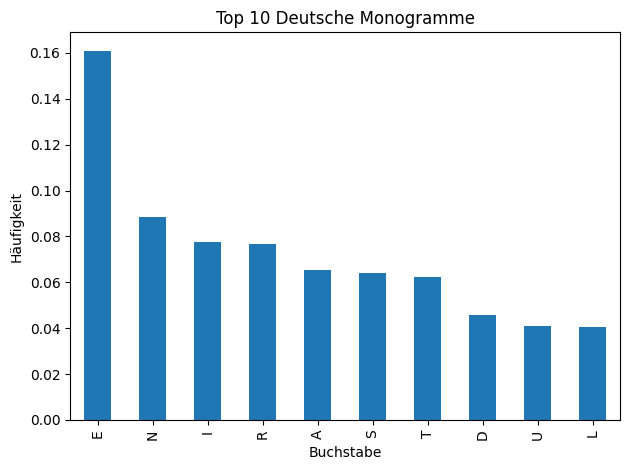

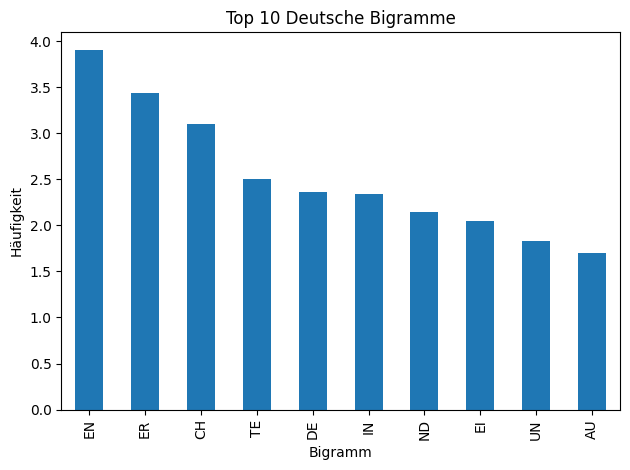

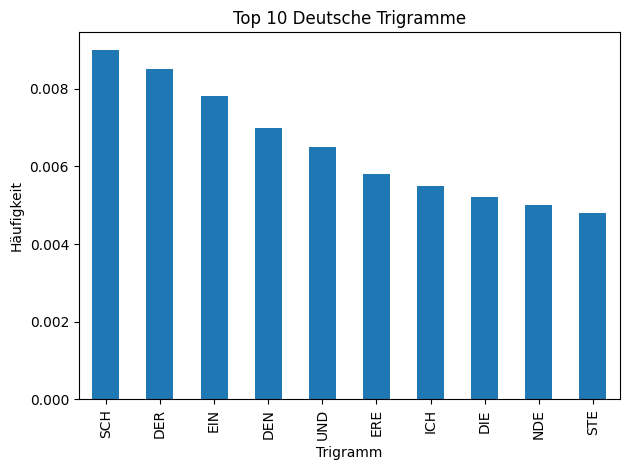

In [ ]:
# Visualisiere die Top 10 Häufigkeiten
DE_MONO_FREQ.head(10).plot(kind='bar', title='Top 10 Deutsche Monogramme')
plt.ylabel('Häufigkeit')
plt.xlabel('Buchstabe')
plt.tight_layout()
plt.show()

DE_BI_FREQ.head(10).plot(kind='bar', title='Top 10 Deutsche Bigramme')
plt.ylabel('Häufigkeit')
plt.xlabel('Bigramm')
plt.tight_layout()
plt.show()

DE_TRI_FREQ.head(10).plot(kind='bar', title='Top 10 Deutsche Trigramme')
plt.ylabel('Häufigkeit')
plt.xlabel('Trigramm')
plt.tight_layout()
plt.show()

In [ ]:

def bereinige_text(text):
    """
    Entfernt alle Zeichen außer A-Z und Leerzeichen.
    Wandelt alles in Großbuchstaben um.
    
    WARUM?
    - Vereinfacht die Häufigkeitsanalyse
    - Zahlen, Sonderzeichen würden die Statistik verfälschen
    - Groß-/Kleinschreibung soll keine Rolle spielen
    
    BEISPIEL:
    Input:  "Hallo Welt! 123"
    Output: "HALLO WELT "
    
    PARAMETER:
    - text: Der zu bereinigende Text (String)
    
    RÜCKGABE:
    - Bereinigter Text (String, nur A-Z und Leerzeichen)
    """
    text = text.upper() # Gesamttext in Großbuchstaben umwandeln
    sauberer_text = '' # Initialisiere leeren String
    for char in text: # Iteriere über jedes Zeichen
        if 'A' <= char <= 'Z' or char == ' ': # Nur A-Z und Leerzeichen erlauben
            sauberer_text += char # Zeichen zum bereinigten Text hinzufügen
    return sauberer_text # Bereinigten Text zurückgeben

In [ ]:
def zaehle_frequenzen(text):
    """
    Zählt Häufigkeiten von Mono-, Bi- und Trigrammen in einem Text.
    
    ALGORITHMUS:
    1. Bereinige den Text (nur A-Z + Leerzeichen)
    2. Zähle jedes Zeichen (Monogramme)
    3. Zähle jedes Zeichenpaar (Bigramme)
    4. Zähle jedes Zeichen-Tripel (Trigramme)
    5. Berechne relative Häufigkeiten (Anzahl / Gesamtzahl)
    6. Sortiere nach Häufigkeit (höchste zuerst)
    
    PARAMETER:
    - text: Der zu analysierende Text (String)
    
    RÜCKGABE:
    - Drei Dictionaries (mono_freq, bi_freq, tri_freq)
    - Format: {'E': 0.1234, 'N': 0.0987, ...}
    - Sortiert nach absteigender Häufigkeit
    """
    ALPHABET = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ '
    text = bereinige_text(text)
    n = len(text) # Länge des bereinigten Textes
    if n == 0: # Falls leerer Text, keine Häufigkeiten zählen
        return {}, {}, {}
    
    
    mono_counts = {char: 0 for char in ALPHABET} #  Initialisiere Zähler für jeden Buchstaben mit 0
    for char in text: # Iteriere über jedes Zeichen
        mono_counts[char] += 1
    mono_freq = {char: count / n for char, count in mono_counts.items()}  #Berechne relative Häufigkeiten (Anzahl / Textlänge)
    mono_freq_sorted = dict(sorted(mono_freq.items(), key=lambda item: item[1], reverse=True)) #Sortiere nach Häufigkeit (höchste zuerst)
    # lambda item: item[1] bedeutet: sortiere nach dem Wert

    bi_counts = {}
    for i in range(n - 1): # Gehe durch den Text und betrachte immer 2 aufeinanderfolgende Zeichen
        biagram = text[i:i+2] # Extrahiere das Bigramm
        bi_counts[biagram] = bi_counts.get(biagram, 0) + 1 # Zähle das Bigramm

    bi_freq = {biagram: count / (n - 1) for biagram, count in bi_counts.items()} # Berechne relative Häufigkeiten
    # Teile durch (n-1), weil wir n-1 Bigramme haben
    bi_freq_sorted = dict(sorted(bi_freq.items(), key=lambda item: item[1], reverse=True))

    #Analog zu Trigrammen
    tri_counts = {}
    for i in range(n - 2):
        triagram = text[i:i+3]
        tri_counts[triagram] = tri_counts.get(triagram, 0) + 1

    tri_freq = {triagram: count / (n - 2) for triagram, count in tri_counts.items()}
    tri_freq_sorted = dict(sorted(tri_freq.items(), key=lambda item: item[1], reverse=True))

    return mono_freq_sorted, bi_freq_sorted, tri_freq_sorted

In [ ]:
def frequenz_angriff(ciphertext):
    """
    Führt einen Häufigkeitsangriff auf einen Geheimtext durch.
    
    STRATEGIE:
    1. Analysiere Häufigkeiten im Geheimtext
    2. Vergleiche mit deutschen Häufigkeiten
    3. Ordne häufigste Geheimtext-Buchstaben den häufigsten deutschen zu
    4. Erstelle einen Substitutionsschlüssel (Geheim -> Klar)
    
    BEISPIEL:
    - Häufigster Buchstabe im Geheimtext: 'P'
    - Häufigster Buchstabe im Deutschen: 'E'
    - Vermutung: P -> E
    
    PARAMETER:
    - ciphertext: Der verschlüsselte Text (String)
    
    RÜCKGABE:
    - schluessel_mono: Dictionary mit Substitutionsregeln
      Format: {'P': 'E', 'U': 'N', 'L': 'I', ...}
    """
    # Zähle Häufigkeiten im Geheimtext
    mono_freq, bi_freq, tri_freq = zaehle_frequenzen(ciphertext)
    
    # Extrahiere die Buchstaben in Reihenfolge der Häufigkeit
    mono_freq_chars = list(mono_freq.keys())
    klar_mono_chars = DE_MONO_CHARS

    # Erstelle den Substitutionsschlüssel basierend auf Häufigkeiten
    schluessel_mono = {}
    # Wie viele Buchstaben können wir zuordnen?
    # (Minimum von beiden Listen, falls eine kürzer ist)
    num_to_map = min(len(mono_freq_chars), len(klar_mono_chars))

    # Ordne die häufigsten Geheimtext-Buchstaben den häufigsten deutschen zu
    for i in range(num_to_map):
       geheim_char = mono_freq_chars[i]
       klar_char = klar_mono_chars[i]
       schluessel_mono[geheim_char] = klar_char

    print("\n[Häufigkeits-Analyse des Geheimtextes]")
    print(f"Top 10 Geheimtext-Buchstaben (nach Häufigkeit): {mono_freq_chars[:10]}")
    print(f"Top 10 Deutsche Klartext-Buchstaben:            {klar_mono_chars[:10]}")
    print(f"Vorgeschlagener Anfangsschlüssel (Geheim -> Klar):")
    
    # Ausgabe der Top 10 Mappings
    for i in range(min(10, len(mono_freq_chars))):
        geheim = mono_freq_chars[i]
        if geheim in schluessel_mono:
            klar = schluessel_mono[geheim]
            print(f"  {geheim} -> {klar}")

    print(f"\nTop 10 Geheimtext Bigramme: {list(bi_freq.keys())[:10]}")
    print(f"Häufigste deutsche Bigramme: {DE_BI_CHARS[:10]}")
    
    print(f"\nTop 10 Geheimtext Trigramme: {list(tri_freq.keys())[:10]}")
    print(f"Häufigste deutsche Trigramme: {DE_TRI_CHARS[:10]}")
    
    return schluessel_mono

    

In [ ]:
def entschluesseln(ciphertext, schluessel):
    """
    Wendet einen Substitutionsschlüssel auf einen Geheimtext an.
    
    ALGORITHMUS:
    - Gehe durch jeden Buchstaben im Geheimtext
    - Falls Buchstabe im Schlüssel enthalten: ersetze ihn
    - Falls nicht: behalte ihn unverändert bei
    
    BEISPIEL:
    - Geheimtext: "PMLLO"
    - Schlüssel: {'P': 'H', 'M': 'E', 'L': 'L', 'O': 'O'}
    - Klartext: "HELLO"
    
    PARAMETER:
    - ciphertext: Der verschlüsselte Text (String)
    - schluessel: Dictionary mit Substitutionsregeln (Dict)
    
    RÜCKGABE:
    - plaintext: Der (teilweise) entschlüsselte Text (String)
    """   
    plaintext = ''
    for char in ciphertext:
        if char in schluessel:
            plaintext += schluessel[char]
        else:
            plaintext += char  # Unveränderte Zeichen beibehalten
    return plaintext


In [7]:

cipher_path = Path('ciphertext.txt')
if not cipher_path.exists():
    print("ERROR: 'ciphertext.txt' not found!")
    print("Please create a file named 'ciphertext.txt' with your encrypted text.")
    ciphertext = ""
else:
    ciphertext = cipher_path.read_text(encoding='utf-8')
    print(f"Ciphertext geladen: {len(ciphertext)} Zeichen")
    print(f"Erste 100 Zeichen: {ciphertext[:100]}")

Ciphertext geladen: 459 Zeichen
Erste 100 Zeichen: VPY YPLNPN GE GQFPN CJYKS UFKSN JUC VLUC?
PG LGN CPY ZFNPY WLN GPLUPW HLUC;
PY SFN CPU HUFDPU VESO L


In [8]:
if ciphertext:
    print("\nStarte Häufigkeitsanalyse...")
    vorgeschlagener_schluessel = frequenz_angriff(ciphertext)
    
    # Wende Schlüssel an
    versuchter_klartext = entschluesseln(ciphertext, vorgeschlagener_schluessel)
    
    print("\n" + "="*60)
    print("[ERGEBNIS DER AUTOMATISCHEN ENTSCHLÜSSELUNG]")
    print("="*60)
    print(f"\nErste 200 Zeichen des entschlüsselten Textes:")
    print(versuchter_klartext[:200])
    print("\n" + "="*60)
else:
    print("Kein Ciphertext verfügbar!")


Starte Häufigkeitsanalyse...

[Häufigkeits-Analyse des Geheimtextes]
Top 10 Geheimtext-Buchstaben (nach Häufigkeit): [' ', 'P', 'U', 'L', 'G', 'N', 'Y', 'C', 'S', 'F']
Top 10 Deutsche Klartext-Buchstaben:            ['E', 'N', 'I', 'R', 'A', 'S', 'T', 'D', 'U', 'L']
Vorgeschlagener Anfangsschlüssel (Geheim -> Klar):
    -> E
  P -> N
  U -> I
  L -> R
  G -> A
  N -> S
  Y -> T
  C -> D
  S -> U
  F -> L

Top 10 Geheimtext Bigramme: ['U ', 'N ', ' G', 'PY', 'LU', 'Y ', ' C', 'KS', 'CP', 'PU']
Häufigste deutsche Bigramme: ['EN', 'ER', 'CH', 'TE', 'DE', 'IN', 'ND', 'EI', 'UN', 'AU']

Top 10 Geheimtext Trigramme: ['PY ', ' CP', 'PLU', 'PU ', 'N C', 'GN ', ' WL', 'LU ', ' GE', 'KS ']
Häufigste deutsche Trigramme: ['SCH', 'DER', 'EIN', 'DEN', 'UND', 'ERE', 'ICH', 'DIE', 'NDE', 'STE']

[ERGEBNIS DER AUTOMATISCHEN ENTSCHLÜSSELUNG]

Erste 200 Zeichen des entschlüsselten Textes:
WNTETNRSNSEAOEAZLNSEDGTCUEILCUSEGIDEWRID?
NAERASEDNTEVLSNTEHRSEANRINHEKRID;
NTEULSEDNIEKILFNIEWOUMERIEDNHELTH,
NTEPL